# Obtaining patterns of cell-cell communication with Tensor-cell2cell

This tutorial is focused on running Tensor-cell2cell on a single-cell dataset. In this case, we use samples from patients with Autism Spectrum Disorders, previously published on https://doi.org/10.1126/science.aav8130. Specifically, we explore how cell-cell communication is shaped by the ASD condition in the prefrontal brain cortex of patients.

**Read this if you plan using a GPU to speed-up the analysis.** Before running this notebook, make sure to have a proper NVIDIA GPU driver (https://www.nvidia.com/Download/index.aspx) as well as the CUDA toolkit (https://developer.nvidia.com/cuda-toolkit) installed.

Then, make sure to create an environment with Pytorch >= v1.8.0 following these instructions to enable CUDA.

https://pytorch.org/get-started/locally/

Once you have everything installed, run the next blocks two blocks of code before everything.

**If you are using a NVIDIA GPU, with PyTorch and CUDA, set the following variable to be True**

```use_gpu = True```

In [1]:
use_gpu = False

In [2]:
if use_gpu:
    import tensorly as tl
    tl.set_backend('pytorch')

In [3]:
import cell2cell as c2c
import scanpy as sc

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
c2c.__version__

'0.5.10'

**IMPORTANT: In this notebook, the version 0.5.10 of cell2cell is used. This may cause subtle differences in the results in comparison to the results in the manuscript of Tensor-cell2cell (performed with the version 0.5.9).**

## Load Data

**Specify folders where the data is located, and where the outputs will be written:**

In [6]:
import os

data_folder = './'
directory = os.fsencode(data_folder)

output_folder = './results/'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

### RNA-seq data

In this case, the expression matrix was obtained from: https://cells.ucsc.edu/autism/exprMatrix.tsv.gz
<br>Values are 10x UMI counts from cellranger, log2-transformed

Metadata was obtained from: https://cells.ucsc.edu/autism/meta.tsv

In [7]:
rnaseq = sc.read_text(data_folder + '/exprMatrix.tsv.gz')
rnaseq = rnaseq.transpose()
meta = pd.read_csv(data_folder + '/meta.tsv', sep='\t', index_col=0)
rnaseq.obs = rnaseq.obs.join(meta)

**Alternatively, a H5AD file can be downloaded from** 

https://codeocean.com/capsule/9737314/tree/v2

(look for the file in the /data/Brain-ASD/ folder)

In [8]:
# rnaseq = sc.read_h5ad(data_folder + '/Brain-ASD/Brain_ASD.h5ad')

**Inspect the object**

In [9]:
rnaseq

AnnData object with n_obs × n_vars = 104559 × 36501
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'

**Select only samples from the prefrontal cortex (PFC)**

This step could be skipped in other datasets where you want to use all samples.

In [10]:
brain_area = 'PFC'

In [11]:
rnaseq = rnaseq[rnaseq.obs.region == brain_area]

In [12]:
rnaseq

View of AnnData object with n_obs × n_vars = 62166 × 36501
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'

### Data for Ligand-Receptor pairs

Different databases of ligand-receptor interactions could be used. We previously created a repository that includes many available DBs (https://github.com/LewisLabUCSD/Ligand-Receptor-Pairs). In this tutorial, we employ the ligand-receptor pairs from CellChat (https://doi.org/10.1038/s41467-021-21246-9), which includes multimeric protein complexes.

In [13]:
lr_pairs = pd.read_csv('https://raw.githubusercontent.com/LewisLabUCSD/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')
lr_pairs = lr_pairs.astype(str)

In [14]:
lr_pairs.head(2)

,interaction_name,pathway_name,ligand,receptor,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2,ligand_symbol,receptor_symbol,ligand_ensembl,receptor_ensembl,interaction_symbol,interaction_ensembl
0,TGFB1_TGFBR1_TGFBR2,TGFb,TGFB1,TGFbR1_R2,TGFb agonist,TGFb antagonist,nan,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB1 - (TGFBR1+TGFBR2),TGFB1,TGFBR1&TGFBR2,ENSG00000105329,ENSG00000106799&ENSG00000163513,TGFB1^TGFBR1&TGFBR2,ENSG00000105329^ENSG00000106799&ENSG00000163513
1,TGFB2_TGFBR1_TGFBR2,TGFb,TGFB2,TGFbR1_R2,TGFb agonist,TGFb antagonist,nan,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB2 - (TGFBR1+TGFBR2),TGFB2,TGFBR1&TGFBR2,ENSG00000092969,ENSG00000106799&ENSG00000163513,TGFB2^TGFBR1&TGFBR2,ENSG00000092969^ENSG00000106799&ENSG00000163513


Next, we specify the column where the ligand and receptors are containing for each interaction. Here, the idea is to use names that match those in the expression matrix.

In [15]:
int_columns = ('ligand_symbol', 'receptor_symbol')

## Data Preprocessing

### RNA-seq

**Organize data to create tensor**

First, generate a dictionary indicating what condition group is associated to each sample/context

In [16]:
context_dict = dict()

for diag, df in rnaseq.obs.groupby('diagnosis'):
    for donor in df['sample'].unique():
        context_dict[donor] = diag

In [17]:
context_dict

{'5144_PFC': 'ASD',
 '5278_PFC': 'ASD',
 '5294_BA9': 'ASD',
 '5403_PFC': 'ASD',
 '5419_PFC': 'ASD',
 '5531_BA9': 'ASD',
 '5565_BA9': 'ASD',
 '5841_BA9': 'ASD',
 '5864_BA9': 'ASD',
 '5939_BA9': 'ASD',
 '5945_PFC': 'ASD',
 '5978_BA9': 'ASD',
 '6033_BA9': 'ASD',
 '4341_BA46': 'Control',
 '5387_BA9': 'Control',
 '5408_PFC_Nova': 'Control',
 '5538_PFC_Nova': 'Control',
 '5577_BA9': 'Control',
 '5879_PFC_Nova': 'Control',
 '5893_PFC': 'Control',
 '5936_PFC_Nova': 'Control',
 '5958_BA9': 'Control',
 '5976_BA9': 'Control'}

In [18]:
context_names = list(context_dict.keys())

**Generate list of RNA-seq data aggregated into cell types**

Here, we convert the single-cell expression levels into cell-type expression levels.
A basic context-wise preprocessing is performed here, keeping only genes that are expressed at least in 4 single cells.

The final list includes the aggregated gene expression of all context, following the same order as the previous dictionary (context_dict).

The aggregation here corresponds to the fraction of single cells for a given cell type that have non-zero expression levels. ***Other aggregation methods could be used, as for example the average expression across single cells in a cell type. Additionally, other gene expression values could be passed, using other preprocessing approaches such as log(x+1) or batch correction methods.***

In [19]:
rnaseq_matrices = []

# Iteraty by sample/context
for context in tqdm(context_names):
    # Obtain metadata for context
    meta_context = rnaseq.obs.loc[rnaseq.obs['sample'] == context]
    # Single cells in the context
    cells = list(meta_context.index)
    
    # Rename index name to identify the barcodes when aggregating expression
    meta_context.index.name = 'barcode'
    
    # Subset RNAseq data by the single cells in the sample/context
    tmp_data = rnaseq[cells]
    
    # Keep genes in each sample with at least 4 single cells expressing it
    sc.pp.filter_genes(tmp_data, min_cells=4)

    # Aggregate gene expression of single cells into cell types
    exp_df = c2c.preprocessing.aggregate_single_cells(rnaseq_data=tmp_data.to_df(),
                                                      metadata=meta_context,
                                                      barcode_col='barcode',
                                                      celltype_col='cluster',
                                                      method='nn_cell_fraction',
                                                     )

    rnaseq_matrices.append(exp_df)

  0%|          | 0/23 [00:00<?, ?it/s]

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attrib

In [20]:
# Change gene names to ensembl (here they are annotated as ENSEMBL|SYMBOL)
matrices = []
for rna in rnaseq_matrices:
    tmp = rna.copy()
    tmp.index = [idx.split('|')[0] for idx in rna.index]
    matrices.append(tmp)

In [21]:
genes = set()
for i, rna in enumerate(rnaseq_matrices):
    if i == 0:
        genes = genes.union(set(rna.index))
    else:
        genes.intersection(set(rna.index))

In [22]:
len(genes)

24298

### LR pairs

Remove bidirectionality in the list of ligand-receptor pairs. That is, remove repeated interactions where both interactions are the same but in different order:

From this list:

| Ligand | Receptor |
| --- | --- |
| Protein A | Protein B |
| Protein B | Protein A |

We will have:

| Ligand | Receptor |
| --- | --- |
| Protein A | Protein B |

In [23]:
lr_pairs = c2c.preprocessing.ppi.remove_ppi_bidirectionality(ppi_data=lr_pairs, 
                                                             interaction_columns=int_columns
                                                             )

Removing bidirectionality of PPI network


In [24]:
lr_pairs.shape

(1988, 17)

**Generate a dictionary with function info for each LR pairs.**

Keys are ***LIGAND_NAME^RECEPTOR_NAME*** (this is the same nomenclature that will be used when building the 4D-communication tensor later), and values are the function in the annotation column in the dataframe containing ligand-receptor pairs. ***Other functional annotations of the LR pairs could be used if available.***

In [25]:
ppi_functions = dict()

for idx, row in lr_pairs.iterrows():
    ppi_label = row[int_columns[0]] + '^' + row[int_columns[1]]
    ppi_functions[ppi_label] = row['annotation']

**Convert interactions from ensembl to symbol**

This will help to rename the LR pairs later into symbols, which are easier to interpret. This ensembl-symbol convertion is not necessary if using gene expression matrices directly with symbol names of genes.

In [26]:
ensembl_symbol = dict()

for idx, row in lr_pairs.iterrows():
    ensembl_symbol[row['interaction_ensembl']] = row['interaction_symbol']

## Tensor-cell2cell Analysis

### Build 4D-Communication Tensor

Here we use as input the list of gene expression matrices that were aggregated into a cell-type granularity. This list contains the expression matrices of all samples/contexts.

```how='inner'``` is used to keep only cell types and genes that are across all contexts. Use ```how='outer'``` to include all cell types, even if they are not in all samples/contexts.

```complex_sep='&'``` is used to specify that the list of ligand-receptor pairs contains protein complexes and that subunits are separated by '&'. If the list does not have complexes, use ```complex_sep=None``` instead.

In [27]:
tensor = c2c.tensor.InteractionTensor(rnaseq_matrices=matrices,
                                      ppi_data=lr_pairs,
                                      context_names=context_names,
                                      how='inner',
                                      complex_sep='&',
                                      interaction_columns=('ligand_ensembl', 'receptor_ensembl'),
                                      communication_score='expression_mean',
                                     )

Getting expression values for protein complexes
Building tensor for the provided context


In [28]:
tensor.tensor.shape

(23, 749, 16, 16)

In [29]:
# If using a GPU, convert tensor & mask into a GPU-manipulable object.
if use_gpu:
    tensor.tensor = tl.tensor(tensor.tensor, device='cuda:0')
    if tensor.mask is not None:
        tensor.mask = tl.tensor(tensor.mask, device='cuda:0')

In [30]:
# Put LR pair names from ensembl to symbol
tensor.order_names[1] = [ensembl_symbol[lr] for lr in tensor.order_names[1]]

**Generate a list containing metadata for each tensor order/dimension - Later used for coloring factor plots**

This is a list containing metadata for each dimension of the tensor (contexts, LR pairs, sender cells, receiver cells). Each metadata corresponds to a dataframe with info of each element in the respective dimension.

In [31]:
meta_tf = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                              metadata_dicts=[context_dict, ppi_functions, None, None],
                                              fill_with_order_elements=True
                                             )

For example, the metadata of the contexts looks like this:

In [32]:
meta_tf[0]

,Element,Category
0,5144_PFC,ASD
1,5278_PFC,ASD
2,5294_BA9,ASD
3,5403_PFC,ASD
4,5419_PFC,ASD
5,5531_BA9,ASD
6,5565_BA9,ASD
7,5841_BA9,ASD
8,5864_BA9,ASD
9,5939_BA9,ASD


### Run Analysis

**For selecting the number of factors to decompose CCC,** we could do it either manually  or automatically from an Elbow analysis.

In this case, after running the Elbow analysis, we manually selected the number of factors.

  0%|          | 0/25 [00:00<?, ?it/s]

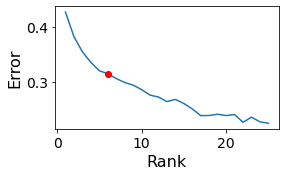

In [33]:
elbow, error = tensor.elbow_rank_selection(upper_rank=25,
                                           runs=1, # This can be increased for more robust results
                                           init='random',
                                           automatic_elbow=False,
                                           random_state=888,
                                          )

# If automatic_elbow=True, remove these two lines. To save the figure in that case,
# add the parameter filename=output_folder + 'Elbow.svg' in the previous function.
# The number of factors will be saved in tensor.rank
_ = plt.plot(*error[5], 'ro') # Here we selected a number of 6 factors.
plt.savefig(output_folder + 'Elbow.svg', dpi=300, bbox_inches='tight')

**Perform tensor factorization**

In [34]:
tensor.compute_tensor_factorization(rank=6,
                                    init='svd', 
                                    random_state=888
                                   )
# init='svd' helps to get an global-optimal solution.
# Replace by 'random' if a memory error is obtained.

### Results

**Plot factor loadings**

After performing the tensor factorization/decomposition, a set of loadings is obtained in a factor-specific way. These loadings provide details of what elements of each dimension are important within each factor.

In [35]:
# Color palettes for each of the tensor dimensions.
cmaps = ['viridis', 'Dark2_r', 'tab20', 'tab20']

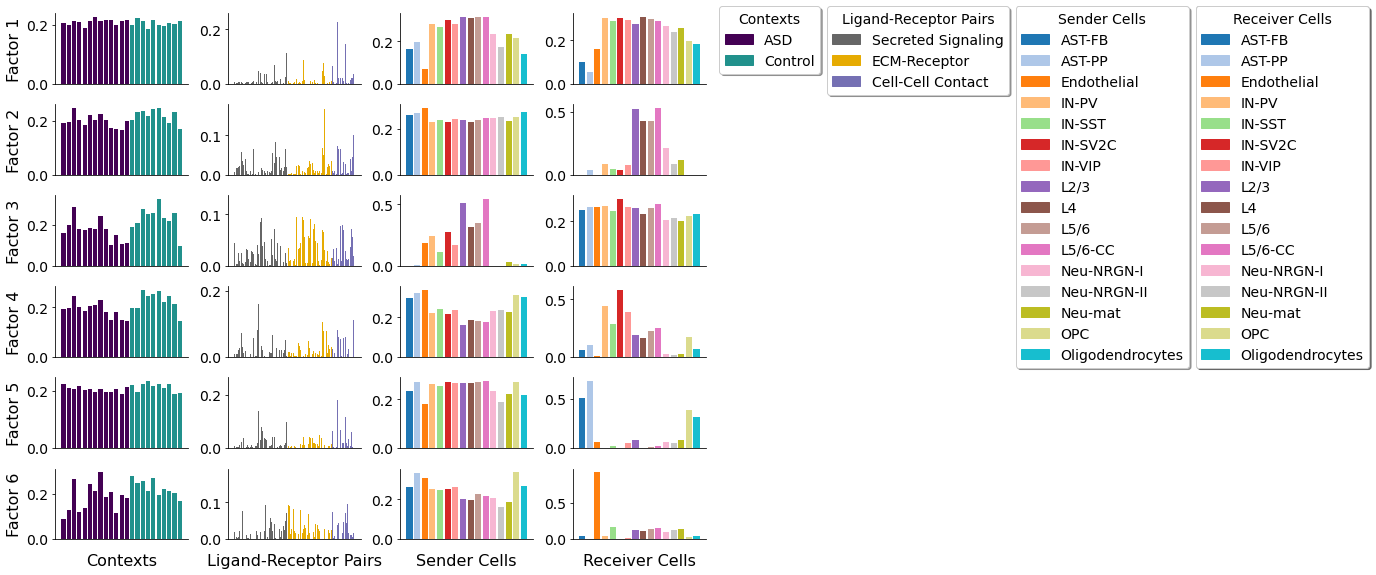

In [36]:
factors, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                                 metadata = meta_tf, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps=cmaps,
                                                 fontsize=14,
                                                 filename=output_folder + 'Tensor-Factorization.svg'
                                                )

**Top-10 LR pairs from their factor-specific loadings**

In [37]:
for i in range(tensor.rank):
        print(tensor.get_top_factor_elements(order_name='Ligand-Receptor Pairs', 
                                             factor_name='Factor {}'.format(i+1), 
                                             top_number=10))
        print('')

NEGR1^NEGR1    0.245580
NRXN3^NLGN1    0.236890
NRXN1^NLGN1    0.234088
CNTN1^NRCAM    0.224620
NCAM1^NCAM1    0.217748
NCAM1^NCAM2    0.207927
NRG3^ERBB4     0.194087
NRXN2^NLGN1    0.193669
NRXN3^NLGN2    0.166386
NRXN3^NLGN3    0.164240
Name: Factor 1, dtype: float64

LAMA2^SV2B    0.169643
LAMA4^SV2B    0.165446
LAMB2^SV2B    0.162802
LAMA1^SV2B    0.159729
LAMA3^SV2B    0.158929
LAMC3^SV2B    0.158480
LAMC2^SV2B    0.157097
LAMA5^SV2B    0.156795
LAMC1^SV2B    0.154253
LAMB1^SV2B    0.153554
Name: Factor 2, dtype: float64

NRG1^ERBB2&ERBB4    0.130066
NRG1^ERBB2&ERBB3    0.129851
NRG1^ERBB3          0.129237
NRG1^ERBB4          0.119872
EFNA5^EPHB2         0.114581
EFNA5^EPHA3         0.107402
EFNA5^EPHA7         0.101061
EFNA5^EPHA4         0.098312
EFNA5^EPHA5         0.097571
NECTIN3^PVR         0.096787
Name: Factor 3, dtype: float64

PTN^ALK        0.203844
PTPRM^PTPRM    0.174730
HBEGF^ERBB4    0.162865
NRG3^ERBB4     0.162113
BTC^ERBB4      0.159788
NRG4^ERBB4     0.153001


**Export Loadings for all dimensions of the 4D-communication tensor.**

***THESE VALUES CAN BE USED FOR DOWNSTREAM ANALYSES***

In [38]:
tensor.export_factor_loadings(output_folder + 'Loadings.xlsx')

Loadings of the tensor factorization were successfully saved into ./results/Loadings.xlsx
